## Rice Leaf Detection Using CNN

 <font size="3">We have deviced the project into multiple steps</font>
              
           



 <font size="3">•	Importing Libraries</font>
 
 <font size="3">•	Loading Data</font>
 
 <font size="3"> •	Preparing Dataset</font>
 
 <font size="3"> •	Label Mapping using Json</font>
 
 <font size="3"> •	Data Preproocessing</font>
 
 <font size="3">•	Model Building</font>
 
 <font size="3"> •	Trining</font>
 
 <font size="3"> •	Check</font>

## Importing the Dataset

In [1]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tf-nightly-gpu-2.0-preview
!pip install tf-hub-nightly
!pip install tensorflow==2.0.0-alpha




ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-gpu-2.0-preview


ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-alpha (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow==2.0.0-alpha


In [2]:
# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.10.0'
!pip install -U --pre tensorflow-gp'
!pip install -U --pre tf-nightly-gpu-2.0
!pip install tensorflow-hub
#model.save('path_to_my_model.h5')

ERROR: Invalid requirement: "'tensorflow-hub"
ERROR: Invalid requirement: "tensorflow-gp'"
ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu-2.0 (from versions: none)
ERROR: No matching distribution found for tf-nightly-gpu-2.0


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()



In [4]:
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers



In [5]:
# verify TensorFlow version
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")



Version:  2.10.0
Eager mode:  True
Hub version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


## Loading the dataset

In [8]:
data_dir =r'C:\Users\RAMEEZA AFRA\Downloads\PRCP-1001-RiceLeaf'
train_dir =os.path.join(data_dir, 'Data')
validation_dir = os.path.join(data_dir, 'Validation')



## Prepare training and validation dataset

In [9]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))



total images for training : C:\Users\RAMEEZA AFRA\Downloads\PRCP-1001-RiceLeaf\Data : 75files
total images for validation : C:\Users\RAMEEZA AFRA\Downloads\PRCP-1001-RiceLeaf\Validation : 44files


In [16]:
import json

with open(r'C:\Users\RAMEEZA AFRA\Downloads\classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

print('Number of classes:',len(classes))



['Bacterial_leaf_blight', 'blast', 'brownspot']
Number of classes: 3


## Select the Hub/TF2 module to use

In [17]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}


Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


## Data Preprocessing

In [20]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        horizontal_flip=True,
        width_shift_range=0.2, 
        height_shift_range=0.2,
        shear_range=0.2, 
        zoom_range=0.2,
        fill_mode='nearest' )
else:
    train_datagen = validation_datagen
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        subset="training", 
        shuffle=True, 
        seed=42,
        color_mode="rgb", 
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE)


Found 44 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


## Building the model

In [21]:
#import tensorflow_hub as hub
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,), 
                                   output_shape=IMAGE_SIZE+(3,))
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
     feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
     for layer in base_model.layers[-30:]:
         layer.trainable =True
else:
    feature_extractor.trainable = False
    
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()





Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 22,853,411
Trainable params: 1,050,627
Non-trainable params: 21,802,784
_______________

## Specify Loss Function and Optimizer

In [22]:
#Compile model specifying the optimizer learning rate
LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])


C:\Users\RAMEEZA AFRA\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Training the Model


In [23]:
history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
2/2 [==============================] - 19s 13s/step - loss: 3.7853 - accuracy: 0.2933 - val_loss: 1.4908 - val_accuracy: 0.3409
Epoch 2/30
2/2 [==============================] - 12s 5s/step - loss: 1.0470 - accuracy: 0.6000 - val_loss: 2.3267 - val_accuracy: 0.3182
Epoch 3/30
2/2 [==============================] - 12s 11s/step - loss: 1.4151 - accuracy: 0.5600 - val_loss: 1.8598 - val_accuracy: 0.2727
Epoch 4/30
2/2 [==============================] - 12s 11s/step - loss: 0.5496 - accuracy: 0.7467 - val_loss: 1.5710 - val_accuracy: 0.5227
Epoch 5/30
2/2 [==============================] - 12s 5s/step - loss: 0.3406 - accuracy: 0.8933 - val_loss: 1.6916 - val_accuracy: 0.5000
Epoch 6/30
2/2 [==============================] - 12s 11s/step - loss: 0.4029 - accuracy: 0.7867 - val_loss: 1.5444 - val_accuracy: 0.4545
Epoch 7/30
2/2 [==============================] - 12s 5s/step - loss: 0.4257 - accuracy: 0.8000 - val_loss: 1.3858 - val_accuracy: 0.5000
Epoch 8/30
2/2 [==============

## Check Performance

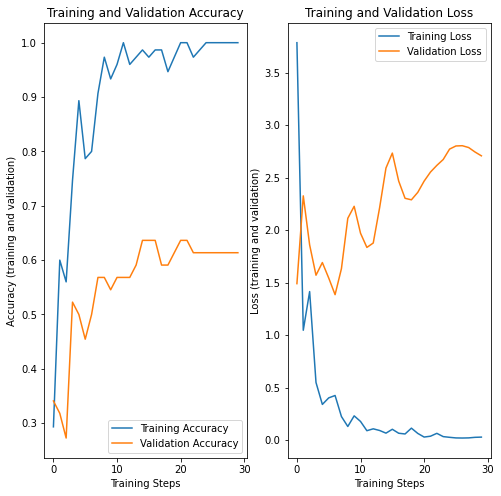

In [24]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()


## Random test

SOURCE: class: Leaf smut-20200814T055530Z-001\Leaf smut, file: Leaf smut-20200814T055530Z-001\Leaf smut\DSC_0506.jpg
1/1 [==============================] - 1s 722ms/step
PREDICTED: class: blast, confidence: 0.979427


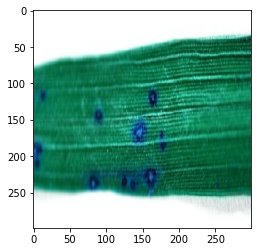

<Figure size 432x288 with 0 Axes>

SOURCE: class: Bacterial leaf blight-20200814T055237Z-001\Bacterial leaf blight, file: Bacterial leaf blight-20200814T055237Z-001\Bacterial leaf blight\DSC_0701.jpg
1/1 [==============================] - 0s 136ms/step
PREDICTED: class: brownspot, confidence: 0.831746


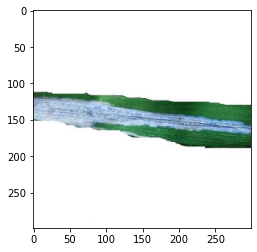

SOURCE: class: Bacterial leaf blight-20200814T055237Z-001\Bacterial leaf blight, file: Bacterial leaf blight-20200814T055237Z-001\Bacterial leaf blight\DSC_0403.JPG
1/1 [==============================] - 0s 123ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.745191


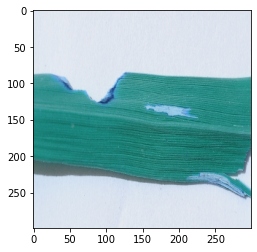

<Figure size 432x288 with 0 Axes>

SOURCE: class: Bacterial leaf blight-20200814T055237Z-001\Bacterial leaf blight, file: Bacterial leaf blight-20200814T055237Z-001\Bacterial leaf blight\DSC_0398.JPG
1/1 [==============================] - 0s 136ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.960627


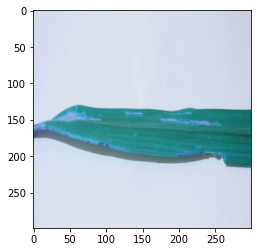

<Figure size 432x288 with 0 Axes>

SOURCE: class: Bacterial leaf blight-20200814T055237Z-001\Bacterial leaf blight, file: Bacterial leaf blight-20200814T055237Z-001\Bacterial leaf blight\DSC_0702.jpg
1/1 [==============================] - 0s 127ms/step
PREDICTED: class: brownspot, confidence: 0.521841


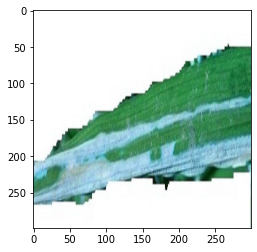

<Figure size 432x288 with 0 Axes>

In [25]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob

def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img

def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()


## Conclusion